In [1]:
import numpy as np
from pathlib import Path
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from models import muq, RoBERTa
import librosa
import soundfile as sf
import torch

SAMPLING_RATE = 44100

def load_soundfiles(path):
    soundfiles = []
    for file in path.iterdir():
        if file.is_dir():
            soundfiles = load_soundfiles(file)
        else:
            if file.suffix in [".wav", ".aif", ".mp3", ".m4a"]:
                data, sr = librosa.load(file, sr=SAMPLING_RATE)
                assert sr == SAMPLING_RATE
                if data.ndim > 1:  # convert to mono
                    data = data.sum(axis=1)
                    data = data / np.abs(data).max()
                # set to 10 seconds
                data = librosa.util.fix_length(data, size=10 * SAMPLING_RATE)
                soundfiles.append(data)
    return soundfiles


def remove_silence(sounds, top_db=60):
    """
    Removes leading and trailing silence from a list of sound arrays.

    Args:
        sounds (list of np.ndarray): List of audio signals as numpy arrays.
        top_db (int): Threshold (in decibels) below reference to consider as silence.

    Returns:
        list of np.ndarray: List of trimmed audio signals.
    """
    trimmed_sounds = []
    for sound in sounds:
        # Check if the whole sound is below the top_db threshold
        if librosa.get_duration(y=sound) == 0 or np.max(np.abs(sound)) < librosa.db_to_amplitude(-top_db):
            continue

        # Trim silence from the beginning and end
        trimmed_sound, _ = librosa.effects.trim(sound, top_db=top_db)
        trimmed_sounds.append(trimmed_sound)
    return trimmed_sounds


def preprocess_sounds(sounds, slice_fn, trim_silence=True):
    if trim_silence:
        sounds = remove_silence(sounds)
    processed_sounds = []
    for sound in sounds:
        slices = slice_fn(sound)
        for slice in slices:
            processed_sounds.append(slice)
    return processed_sounds


# what transformations will we apply to the feature spaces?
def create_pipeline(normalization_method, dim):
    pca = PCA(n_components=dim)
    return [normalization_method.fit_transform, pca.fit_transform]


def load_text_corpus(path):
    assert path.is_file()
    with open(path, "r") as f:
        return [word for line in f.readlines() for word in line.split()]


def embed_sounds(sounds, encoder):
    embeddings = []
    for sound in sounds:
        embedding = encoder(sound, SAMPLING_RATE).squeeze()
        # For MuQ: average across time
        embedding = torch.mean(embedding, dim=0).flatten()
        embeddings.append(embedding)
    return torch.stack(embeddings)


def embed_text(text, encoder):
    return encoder(text)


def find_nearest_neighbors(sound_embeddings, points, distance_metric):
    """

    :param sound_embeddings: The space S of all sound embeddings
    :param points: The text embeddings that have been mapped to S
    :param distance_metric: 'euclidean' or 'cosine'
    :return: neighbor_indices: list of indices that correspond to points in S
    """
    neigh = NearestNeighbors(n_neighbors=1, algorithm='auto', metric=distance_metric).fit(sound_embeddings)
    neighbor_indices = neigh.kneighbors(points, return_distance=False).flatten()
    return neighbor_indices


def save_output(sound_list, output_path):
    # concatenate audio files
    output = np.concatenate(sound_list)

    output_path.mkdir(parents=True, exist_ok=True)
    counter = 0
    while (output_path / f"output{counter}.wav").exists():
        counter += 1

    filename = output_path / f"output{counter}.wav"
    sf.write(filename, output, SAMPLING_RATE)

def equal_slices(sound, grain_size):
    if sound.size < grain_size:
        return [sound]
    return librosa.util.frame(sound, frame_length=grain_size, hop_length=grain_size, axis=0)

C:\Users\dzluk\.conda\envs\QE\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
parameters = {
        "sound_corpus_path": "./corpora/sound/toy",
        "text_corpus_path": "./corpora/text/repeat.txt",
        "sound_encoder": "MuQ",
        "text_encoder": "RoBERTa",
        "output_path": "./output",
        "grain_size": 1000,  # in ms
        "distance": "euclidean",
        "trim_silence": True,
}

# a function that determines how to separate sounds
grain_size = int(parameters['grain_size'] / 1000.0 * SAMPLING_RATE)  # convert to samples
slice_fn = lambda y: equal_slices(y, grain_size)

sound_corpus_path = Path(parameters["sound_corpus_path"])
text_corpus_path = Path(parameters["text_corpus_path"])

if parameters["sound_encoder"] == "MuQ":
    sound_encoder = muq
if parameters["text_encoder"] == "RoBERTa":
    text_encoder = RoBERTa

print("Loading sound and text data...")
sound_corpus = load_soundfiles(sound_corpus_path)
sound_corpus = preprocess_sounds(sound_corpus, slice_fn, parameters["trim_silence"])

text_corpus = load_text_corpus(text_corpus_path)

print("Embedding sounds...")
sound_embeddings = embed_sounds(sound_corpus, sound_encoder)

print("Embedding text...")

text_embeddings = embed_text(" ".join(text_corpus), text_encoder)

Loading sound and text data...
Embedding sounds...


C:\Users\dzluk\.conda\envs\QE\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


MuQ: feature shape:  torch.Size([1, 12, 1024])
MuQ: feature shape:  torch.Size([1, 8, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
MuQ: feature shape:  torch.Size([1, 25, 1024])
Embedding text...


Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa: number of tokens:  10


In [33]:
normalization = StandardScaler()
dim = 2  # the number of dimensions to reduce to

print("Transforming embeddings...")
# what transformations will we apply to the feature space?
transform_pipeline = create_pipeline(normalization, dim)
for transform in transform_pipeline:
    sound_embeddings = transform(sound_embeddings)
    text_embeddings = transform(text_embeddings)

print("Mapping text to sound...")
W = np.eye(dim)
mapped_text_embeddings = [W @ emb for emb in text_embeddings]

print("Finding nearest neighbors...")
neighbor_indices = find_nearest_neighbors(sound_embeddings, mapped_text_embeddings, parameters["distance"])

print("Fetching sounds...")
output_sounds = [sound_corpus[i] for i in neighbor_indices]

print("Saving output...")
save_output(output_sounds, Path(parameters["output_path"]))

print("Done.")

Transforming embeddings...
Mapping text to sound...
Finding nearest neighbors...
Fetching sounds...
Saving output...
Done.


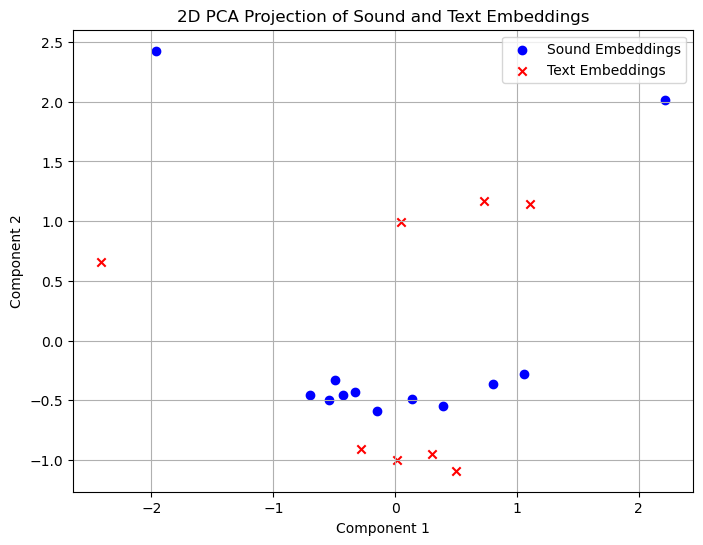

In [36]:
import matplotlib.pyplot as plt

def plot_2d_embeddings(sound_embeddings, text_embeddings):
    plt.figure(figsize=(8, 6))

    # Plot sound embeddings (in blue)
    plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], color='blue', marker='o', label='Sound Embeddings', alpha=1)

    # Plot text embeddings (in red)
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings', alpha=1)

    # Add labels and legend
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection of Sound and Text Embeddings')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_2d_embeddings(sound_embeddings, text_embeddings)

C:\Users\dzluk\AppData\Local\Temp\ipykernel_6212\2590189125.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(highlighted_text[0], highlighted_text[1], color='red', marker='x', s=100, edgecolors='black', label='Input Text', zorder=5)


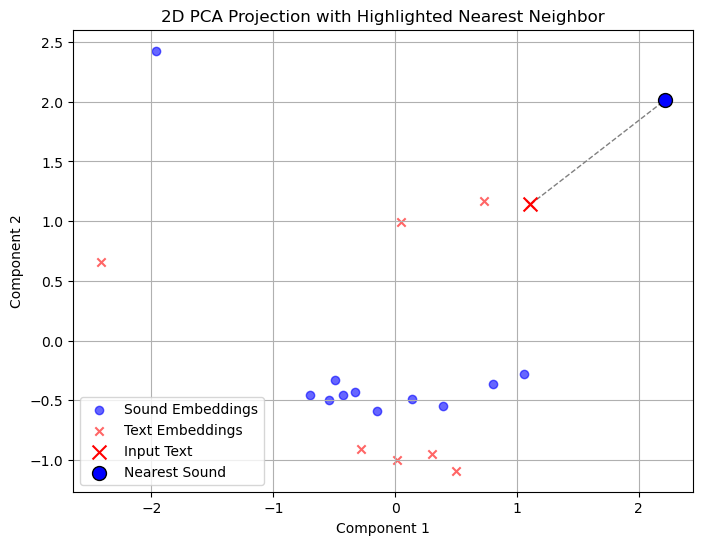

In [37]:
def plot_2d_embeddings_with_highlight(sound_embeddings, text_embeddings, highlighted_text_idx, nearest_sound_idx):
    plt.figure(figsize=(8, 6))

    # Plot all sound embeddings (in blue)
    plt.scatter(sound_embeddings[:, 0], sound_embeddings[:, 1], color='blue', label='Sound Embeddings', alpha=0.6)

    # Plot all text embeddings (in red)
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings', alpha=0.6)

    # Highlight the specific text embedding (in green)
    highlighted_text = text_embeddings[highlighted_text_idx]
    plt.scatter(highlighted_text[0], highlighted_text[1], color='red', marker='x', s=100, edgecolors='black', label='Input Text', zorder=5)

    # Highlight the nearest neighbor sound embedding (in purple)
    nearest_sound = sound_embeddings[nearest_sound_idx]
    plt.scatter(nearest_sound[0], nearest_sound[1], color='blue', s=100, edgecolors='black', label='Nearest Sound', zorder=5)

    # Draw an arrow or line between the points
    plt.plot([highlighted_text[0], nearest_sound[0]],
             [highlighted_text[1], nearest_sound[1]],
             color='gray', linestyle='--', linewidth=1)

    # Add labels and legend
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection with Highlighted Nearest Neighbor')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_2d_embeddings_with_highlight(sound_embeddings, text_embeddings, 6, neighbor_indices[6])

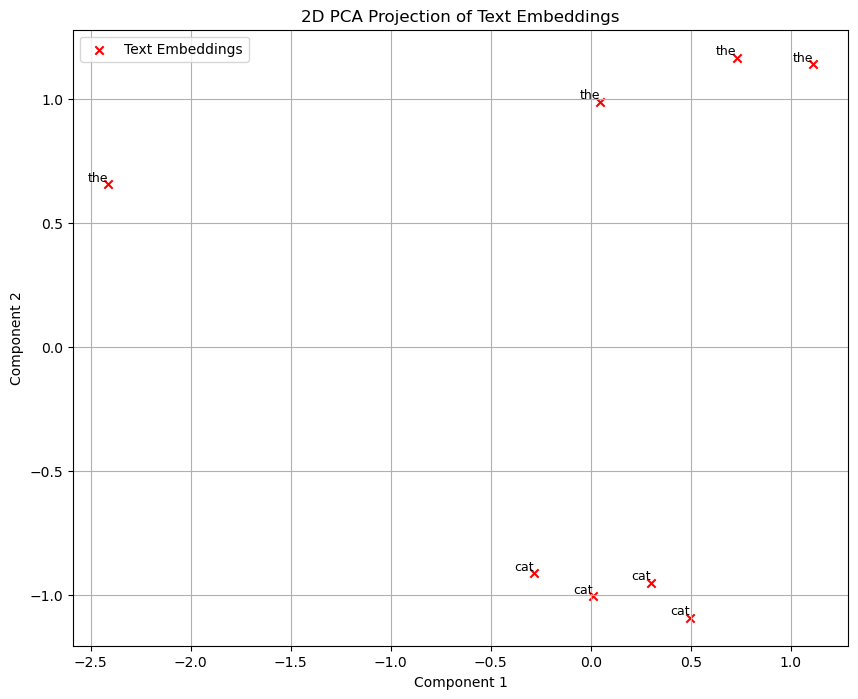

In [35]:
def plot_text_embeddings_with_labels(text_embeddings, text_corpus):
    assert text_embeddings.shape[0] == len(text_corpus)
    plt.figure(figsize=(10, 8))

    # Plot text embeddings with red 'x' markers
    plt.scatter(text_embeddings[:, 0], text_embeddings[:, 1], color='red', marker='x', label='Text Embeddings')

    # Add labels to each point
    for i, word in enumerate(text_corpus):
        plt.text(text_embeddings[i, 0], text_embeddings[i, 1], word, fontsize=9, ha='right', va='bottom')

    # Formatting
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('2D PCA Projection of Text Embeddings')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_text_embeddings_with_labels(text_embeddings, text_corpus)